In [118]:
import arcpy
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
from rasterio.crs import CRS
import rioxarray as rxr
import folium
from folium.plugins import MousePosition
import branca.colormap as cm
from PIL import Image
import io
import base64
from osgeo import gdal, osr
from rasterio.features import shapes
import geopandas as gpd
import shapely.geometry
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
from datetime import datetime
import uuid

In [ ]:
#############STABLISH CONNECTION WITH THE SQL DATABASE########
#The data base has 3.793. fires in Texas

In [3]:
# Define the route of the SQL database
conection_db = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\TX_Wildfire\SQLServer-DAVIDRPR_SQLEXPRESS01-Texas_Fires.sde"

# Verify that conection is valid 
arcpy.env.workspace = conection_db  # Stablished the work enviroment 

In [ ]:
#################################STEP No.SHOW THE BIGGEST FIRE IN TEXAS##################

In [6]:
# Access the table in the SQL databse where the fires are
fire_table = "Fires_TX"

# Create an empty list to host the fires and areas
fires_areas = []
with arcpy.da.SearchCursor(fire_table, ["poly_Incid", "Area"]) as cursor:
    for row in cursor:
        fires_areas.append((row[0], row[1]))
# Order in descending mode
fires_areas.sort(key=lambda x: x[1], reverse=True)

# Show the biggest fire
biggest = fires_areas[0]
print(f"The biggest fire is {biggest[0]} with an area of {biggest[1]} acres.")


The biggest fire is Smokehouse Creek with an area of 1054157.89701 acres.


In [ ]:
#######################STEP No.4 FILTER JUST SMOKEHOUSE CREEK FIRE######################

In [8]:
# Filtrar la tabla para encontrar solo el incendio Smokehouse Creek
biggest_fire = "Smokehouse Creek"  # Nombre correcto del incendio

# Crear una consulta para seleccionar el incendio más grande
consulta = f"poly_Incid = '{biggest_fire}'"

# Usar arcpy.da.SearchCursor para contar los registros que coinciden con la consulta
count_smokehouse = 0
with arcpy.da.SearchCursor(fire_table, ["poly_Incid"], where_clause=consulta) as cursor:
    for row in cursor:
        count_smokehouse += 1

print(f"Number of cases for {biggest_fire}: {count_smokehouse}")

Number of cases for Smokehouse Creek: 1


In [ ]:
################### PREPARE LANDSAT IMAGERY PRE-POST-FIRE #######################

In [10]:
# Raster folder
base_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters"

# Bands to work on
bands = ['B4', 'B5', 'B7']

#
before_stack = []
after_stack = []

# Read bands before and after
for band in bands:
    before_path = os.path.join(base_path, f"{band}_Before_TIF.tif")
    after_path = os.path.join(base_path, f"{band}_After_TIF.tif")

    with rasterio.open(before_path) as src_before:
        before_stack.append(src_before.read(1).astype('float32'))
        profile = src_before.profile  # Para conservar metadata

    with rasterio.open(after_path) as src_after:
        after_stack.append(src_after.read(1).astype('float32'))

# Convert to arrays 3D (bands, rows, cols)
before_array = np.stack(before_stack)
after_array = np.stack(after_stack)

print("Before shape:", before_array.shape)
print("After shape:", after_array.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0], "x", abs(profile['transform'][4]))

Before shape: (3, 2604, 6337)
After shape: (3, 2604, 6337)
CRS: EPSG:4326
Resolution: 0.00030566358387822926 x 0.00030566358387822617


In [ ]:
###########################SHOW A PRE AND POST IMAGES WITHOUT PROCESSING IT###############

C:\Users\rpr_2\AppData\Local\Temp\ipykernel_37500\130590442.py:51: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = rxr.open_rasterio(before_path).isel(band=0).drop('band')
C:\Users\rpr_2\AppData\Local\Temp\ipykernel_37500\130590442.py:51: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = rxr.open_rasterio(before_path).isel(band=0).drop('band')


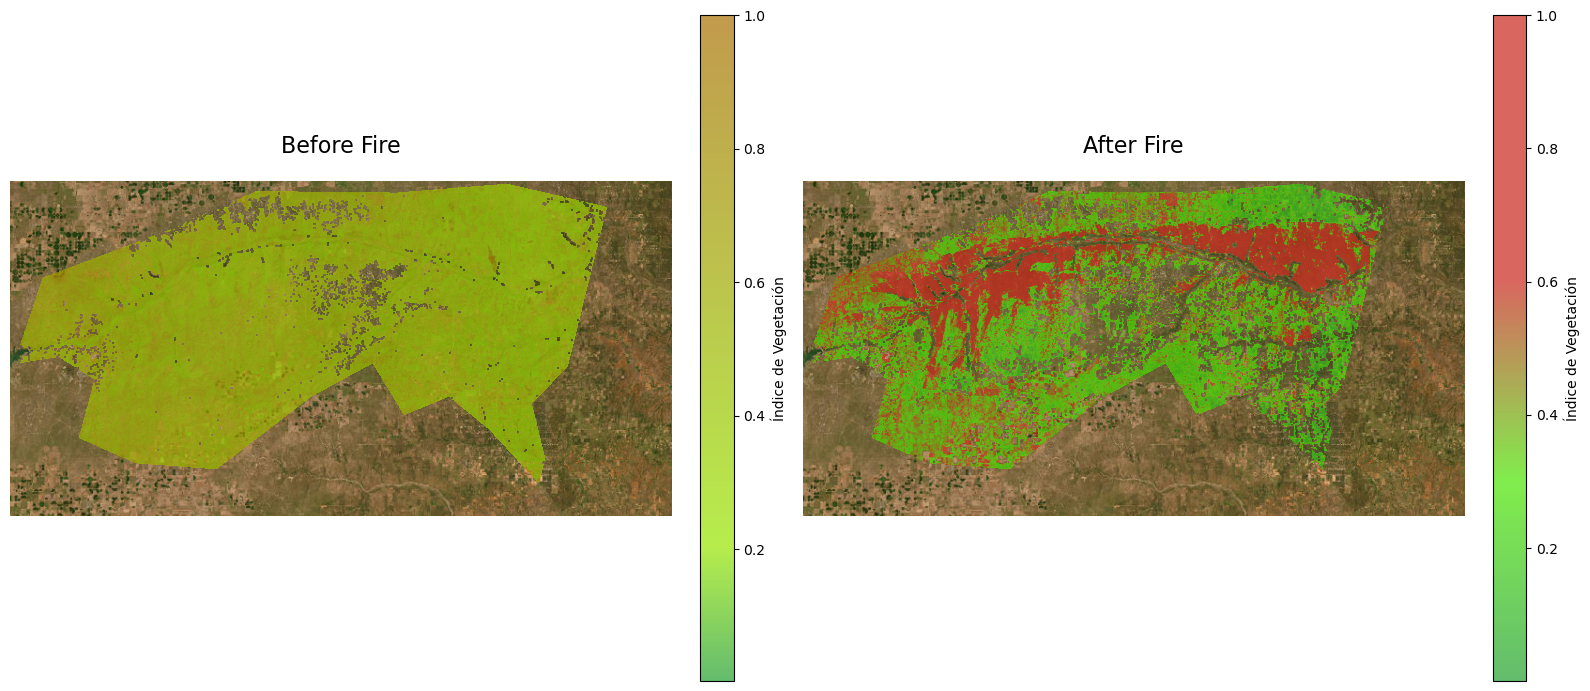

In [13]:
# Function to read and cut all the band to the same size 
def read_and_match_bands(before_path, after_path):
    # Leer ambas imágenes
    with rasterio.open(before_path) as before_src, rasterio.open(after_path) as after_src:
        # Get the common min size
        min_rows = min(before_src.height, after_src.height)
        min_cols = min(before_src.width, after_src.width)
        
        # Read and cut the bands
        before_band = before_src.read(1, window=((0, min_rows), (0, min_cols))).astype(float)
        after_band = after_src.read(1, window=((0, min_rows), (0, min_cols))).astype(float)
        
        # Use the transformation and CRS of the "before" image
        transform = before_src.transform
        crs = before_src.crs
    
    return before_band, after_band, transform, crs

# Función to apply percent clip and gamma
def percent_clip_single_band(band, min_percent, max_percent, gamma=1.0):
    lower = np.percentile(band[band > 0], min_percent)  # Solo valores positivos
    upper = np.percentile(band[band > 0], 100 - max_percent)
    stretched = np.clip((band - lower) / (upper - lower), 0, 1)
    return stretched ** (1 / gamma)

# Colormaps
colors_before = [(0.0, "#22A12F"), (0.20, "#98E600"), (1.0, "#A87000")]
cmap_before = LinearSegmentedColormap.from_list("GreenToBrown", colors_before)

colors_after = [(0.0, "#22A12F"), (0.3, "#4CE600"), (0.60, "#C9261B"), (1.0, "#C9261B")]
cmap_after = LinearSegmentedColormap.from_list("GreenToRed", colors_after)

# Rutas de archivos
before_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B4_Before_TIF.tif"
after_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B4_After_TIF.tif"

# read and transform the bands
before_band, after_band, transform, crs = read_and_match_bands(before_path, after_path)

# Process the bands
before_processed = percent_clip_single_band(before_band, min_percent=0.25, max_percent=0.25, gamma=1.5)
after_processed = percent_clip_single_band(after_band, min_percent=2.0, max_percent=2.0, gamma=1.0)

# Mask no valid values
before_masked = np.ma.masked_where(before_processed <= 0, before_processed)
after_masked = np.ma.masked_where(after_processed <= 0, after_processed)

# Convert to rioxarray
def create_rioxarray(data, transform, crs):
    
    da = rxr.open_rasterio(before_path).isel(band=0).drop('band')
    da = da[:data.shape[0], :data.shape[1]] 
    da.data = data
    da.rio.write_transform(transform, inplace=True)
    da.rio.write_crs(crs, inplace=True)
    return da

before_rxr = create_rioxarray(before_masked, transform, crs)
after_rxr = create_rioxarray(after_masked, transform, crs)

# Reproject to Web Mercator
before_proj = before_rxr.rio.reproject("EPSG:3857")
after_proj = after_rxr.rio.reproject("EPSG:3857")

# Get the common limits
left = min(before_proj.rio.bounds()[0], after_proj.rio.bounds()[0])
right = max(before_proj.rio.bounds()[2], after_proj.rio.bounds()[2])
bottom = min(before_proj.rio.bounds()[1], after_proj.rio.bounds()[1])
top = max(before_proj.rio.bounds()[3], after_proj.rio.bounds()[3])

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Configure axis
for ax in (ax1, ax2):
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ax.axis('off')

# Add to basemap
ctx.add_basemap(ax1, source=ctx.providers.Esri.WorldImagery, attribution=False)
ctx.add_basemap(ax2, source=ctx.providers.Esri.WorldImagery, attribution=False)

# Show Images
extent = [left, right, bottom, top]
im0 = ax1.imshow(before_proj.values, extent=extent, cmap=cmap_before, alpha=0.7)
im1 = ax2.imshow(after_proj.values, extent=extent, cmap=cmap_after, alpha=0.7)

# Add color bars
plt.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04, label='Índice de Vegetación')
plt.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04, label='Índice de Vegetación')

# Titles
ax1.set_title("Before Fire", fontsize=16, pad=20)
ax2.set_title("After Fire", fontsize=16, pad=20)

plt.tight_layout()
plt.show()


In [14]:
!pip install -q rioxarray contextily geopandas

C:\Users\rpr_2\AppData\Local\Temp\ipykernel_37500\2791450830.py:61: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dnbr_rxr = dnbr_rxr.isel(band=0).drop('band')


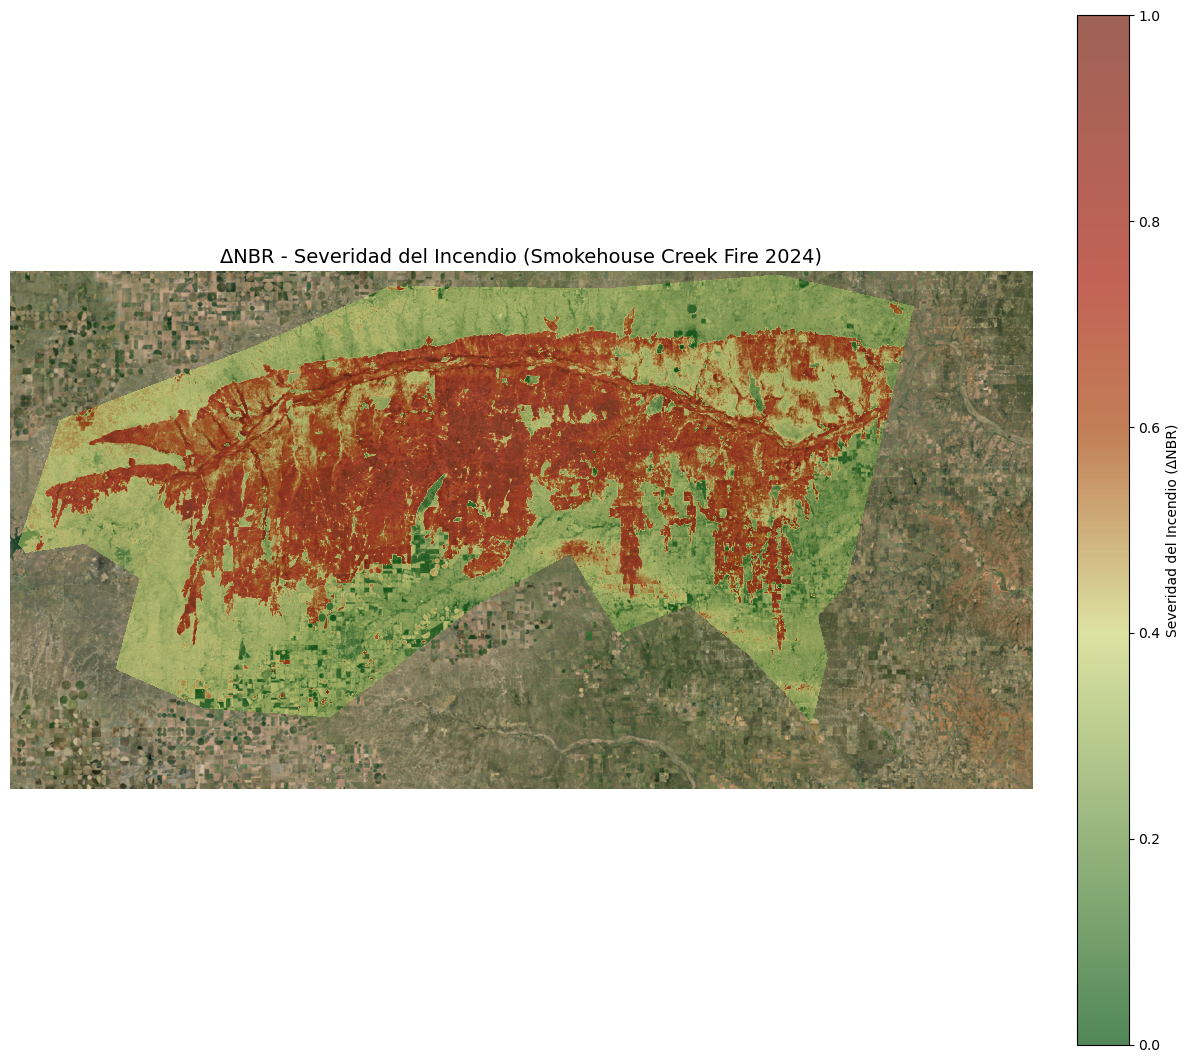

In [15]:
# Function to read the bands
def read_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype('float32'), src.transform, src.crs

# Function to calculate NBR
def calculate_nbr(b5, b7):
    return (b5 - b7) / (b5 + b7 + 0.0001)

# Function to cut
def crop_to_common_shape(arr1, arr2):
    min_rows = min(arr1.shape[0], arr2.shape[0])
    min_cols = min(arr1.shape[1], arr2.shape[1])
    return arr1[:min_rows, :min_cols], arr2[:min_rows, :min_cols]

# Route of the bands
b5_before_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B5_Before_TIF.tif"
b7_before_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B7_Before_TIF.tif"
b5_after_path  = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B5_After_TIF.tif"
b7_after_path  = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B7_After_TIF.tif"

# Read the bands
b5_before, transform, crs = read_band(b5_before_path)
b7_before, _, _ = read_band(b7_before_path)
b5_after, _, _ = read_band(b5_after_path)
b7_after, _, _ = read_band(b7_after_path)

# Cut the bands
b5_before, b5_after = crop_to_common_shape(b5_before, b5_after)
b7_before, b7_after = crop_to_common_shape(b7_before, b7_after)

# Calculate NBR and Delta NBR
nbr_before = calculate_nbr(b5_before, b7_before)
nbr_after  = calculate_nbr(b5_after, b7_after)
dnbr = nbr_before - nbr_after

# Mask to valid values
valid_mask = (b5_before > 0) & (b7_before > 0) & (b5_after > 0) & (b7_after > 0)

# Stretching de ΔNBR 
dnbr_stretched = np.clip((dnbr - np.percentile(dnbr[valid_mask], 2)) /
                         (np.percentile(dnbr[valid_mask], 98) - np.percentile(dnbr[valid_mask], 2)), 0, 1)

# Apply mask to valid values
dnbr_masked = np.where(valid_mask, dnbr_stretched, np.nan)

# Colormap 
colors = [(0.0, "#085513"), (0.4, "#CED67A"), (0.6, "#A8460E"), (0.75, "#A81F0E"), (1.0, "#761F0E")]
cmap_dnbr = LinearSegmentedColormap.from_list("GreenToRed", colors)

# Create figure to visualize
fig, ax = plt.subplots(figsize=(12, 12), facecolor='white')

# Verify CRS configuration
if crs is None:
    crs = CRS.from_epsg(4326)  # Si no hay CRS, usamos EPSG:4326 como predeterminado
    print("Advertencia: No se encontró CRS en los archivos, usando WGS84 (EPSG:4326) por defecto")

# Convert to rioxarray
dnbr_rxr = rxr.open_rasterio(b5_before_path)  
dnbr_rxr = dnbr_rxr.isel(band=0).drop('band')
dnbr_rxr.data = dnbr_masked  
dnbr_rxr.rio.write_transform(transform, inplace=True)
dnbr_rxr.rio.write_crs(crs, inplace=True)

# Reproject to  Web Mercator (EPSG:3857) 
dnbr_proj = dnbr_rxr.rio.reproject("EPSG:3857")

# Obtain limits of CRS
left, bottom, right, top = dnbr_proj.rio.bounds()

# Configure limits
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

# Add basemap
ctx.add_basemap(ax, 
               crs=dnbr_proj.rio.crs.to_string(),
               source=ctx.providers.Esri.WorldImagery,
               zoom=12,
               attribution=False)

# Show ΔNBR reprojected
extent = [left, right, bottom, top]
img = ax.imshow(dnbr_proj.values, extent=extent, cmap=cmap_dnbr, alpha=0.7, vmin=0, vmax=1)

# Add color bar
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
cbar.set_label('Severidad del Incendio (ΔNBR)')


ax.set_title("ΔNBR - Severidad del Incendio (Smokehouse Creek Fire 2024)", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
############ NBR Calculation (Band Arithmetic) and Delta NBR (Map Algebra)###


🔥 TOTAL BURNT AREA: 1,478,166 acres
Severity distribution:
- Low: 852,410 px (81.0%)
- Medium: 132,252 px (12.6%)
- Moderate: 53,447 px (5.1%)
- High: 14,228 px (1.4%)


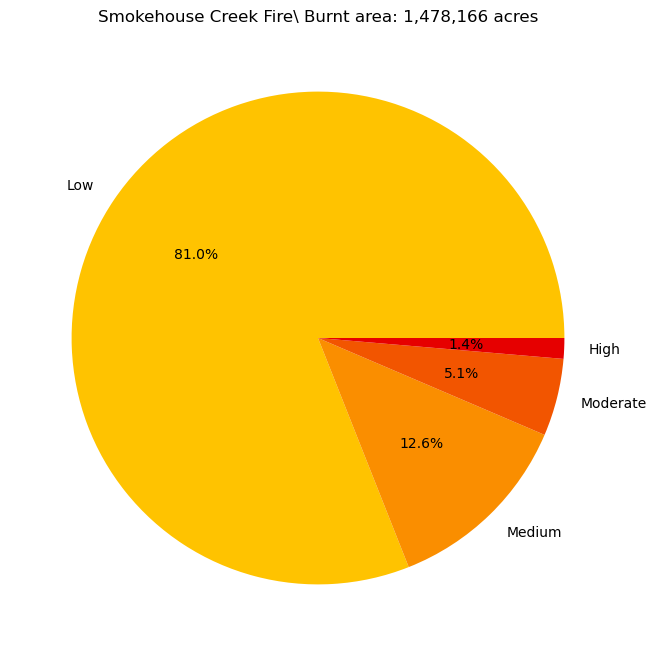

In [31]:
# 1. Severity clasification ΔNBR
severity = np.zeros_like(dnbr, dtype=np.uint8)
severity[(dnbr >= 0.1) & (dnbr < 0.13)] = 1   # low
severity[(dnbr >= 0.14) & (dnbr < 0.16)] = 2  # Medium
severity[(dnbr >= 0.16) & (dnbr < 0.20)] = 3  # Moderate
severity[dnbr >= 0.2] = 4                    # High

# 2. Define the burnt area extension. EPSG:3857 (Web Mercator)
ext = {
    "xmin": dnbr_proj.rio.bounds()[0],
    "ymin": dnbr_proj.rio.bounds()[1],
    "xmax": dnbr_proj.rio.bounds()[2],
    "ymax": dnbr_proj.rio.bounds()[3],
    "spatialReference": {"wkid": 3857}
}

# 3. Calculate pixels
pixx = (ext['xmax'] - ext['xmin']) / 3450  # 1200 píxeles en X
pixy = (ext['ymax'] - ext['ymin']) / 1200.0   # 450 píxeles en Y

# 4. Calculate histogram according to severity classes
histogram = np.bincount(severity[valid_mask].flatten(), minlength=5)[1:]  

# 5. Calculate burnt areas
numpix = sum(histogram)
sqm_area = numpix * pixx * pixy 
acres = sqm_area * 0.000247105   # Conversion to acres

# 6. Results 
print(f"\n🔥 TOTAL BURNT AREA: {acres:,.0f} acres")
print("Severity distribution:")
print(f"- Low: {histogram[0]:,} px ({(histogram[0]/numpix)*100:.1f}%)")
print(f"- Medium: {histogram[1]:,} px ({(histogram[1]/numpix)*100:.1f}%)")
print(f"- Moderate: {histogram[2]:,} px ({(histogram[2]/numpix)*100:.1f}%)")
print(f"- High: {histogram[3]:,} px ({(histogram[3]/numpix)*100:.1f}%)")

# 7. Visualization
plt.figure(figsize=(8, 8))
plt.pie(histogram, 
        labels=['Low', 'Medium', 'Moderate', 'High'],
        colors=['#FFC300', '#FA8E00', '#F25500', '#E60000'],
        autopct='%1.1f%%')
plt.title(f'Smokehouse Creek Fire\ Burnt area: {acres:,.0f} acres')
plt.show()

In [ ]:
########################  Visualize Burn Scars ######################


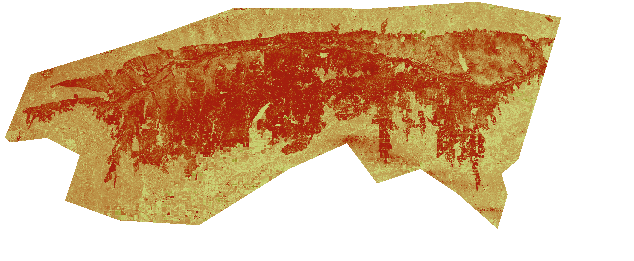

In [55]:
# 1. Configuration of coordinates
south, north = 35.2, 36.1  
west, east = -101.5, -103.5

# 2. Prepare data
def prepare_layer(data, mask, factor=10):
    data_norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
    return np.where(mask, data_norm, np.nan)[::factor, ::factor]

dnbr_layer = prepare_layer(dnbr, valid_mask)

# 3. colors
color_dict = {
    0.0: '#847200',
    0.45: '#CED67A',
    0.55: '#A8460E',
    0.58: '#A81F0E',
    1.0: '#761F0E'
}

# 4. Function to convert HEX to RGB
def hex_to_rgba(hex_color, alpha=255):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) + (alpha,)

# 5. Create and PNG with transparency
def create_transparent_image(data, color_dict):
    
    img = np.zeros((data.shape[0], data.shape[1], 4), dtype=np.uint8)
       
    thresholds = sorted(color_dict.keys())
    colors = [hex_to_rgba(color_dict[t]) for t in thresholds]
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i,j]
            if np.isnan(val):
                img[i,j] = [0, 0, 0, 0]  # Transparente
            else:
                
                for k in range(len(thresholds)-1):
                    if thresholds[k] <= val < thresholds[k+1]:
                        t = (val - thresholds[k]) / (thresholds[k+1] - thresholds[k])
                        img[i,j] = [
                            int(colors[k][0] + t*(colors[k+1][0]-colors[k][0])),
                            int(colors[k][1] + t*(colors[k+1][1]-colors[k][1])),
                            int(colors[k][2] + t*(colors[k+1][2]-colors[k][2])),
                            255
                        ]
                        break
                else:
                    img[i,j] = colors[-1]  
    
    
    png_img = Image.fromarray(img, 'RGBA')
    buffer = io.BytesIO()
    png_img.save(buffer, format='PNG')
    return base64.b64encode(buffer.getvalue()).decode()

# 6. Generate transparent image
png_data = create_transparent_image(dnbr_layer, color_dict)

# 7. Create map
m = folium.Map(
    location=[(south+north)/2, (west+east)/2],
    zoom_start=8,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI World Imagery',
    control_scale=True
)

# 8. Add a transparent layer
folium.raster_layers.ImageOverlay(
    image=f'data:image/png;base64,{png_data}',
    bounds=[[south, west], [north, east]],
    opacity=1.0,
    name='Severidad del Incendio',
    interactive=True,
    cross_origin=False,
    mercator_project=False
).add_to(m)

# 9. Controls
folium.LayerControl().add_to(m)
MousePosition().add_to(m)

# 10. Create manual legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 150px; 
     border:2px solid grey; z-index:9999; font-size:12px;
     background-color:white; padding: 10px;">
     <b>Severidad del Incendio</b><br>
     <i style="background:#085513; width:20px; height:20px; display:inline-block;"></i> Low<br>
     <i style="background:#CED67A; width:20px; height:20px; display:inline-block;"></i> Moderate<br>
     <i style="background:#A8460E; width:20px; height:20px; display:inline-block;"></i> High<br>
     <i style="background:#A81F0E; width:20px; height:20px; display:inline-block;"></i> Very High<br>
     <i style="background:#761F0E; width:20px; height:20px; display:inline-block;"></i> Severe
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# 11. Visualitation
display(m)
m.save('incendio_final_perfecto.html')

In [ ]:
######################### Fire Raster Georeferencing #######################

In [101]:
# 1. Read metada
with rasterio.open(r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Data\Rasters\B4_Before_TIF.tif") as src:
    transform = src.transform
    crs = src.crs
    height, width = src.shape

# 2. Output raster
output_raster = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\smokehouse_severity.tif"

# 3. Function to resize
def simple_resize(array, new_shape):
    if array.shape == new_shape:
        return array
    y = np.linspace(0, array.shape[0]-1, new_shape[0])
    x = np.linspace(0, array.shape[1]-1, new_shape[1])
    xv, yv = np.meshgrid(x, y)
    return array[yv.astype(int), xv.astype(int)]

# 4. Resize the ΔNBR
dnbr_resized = simple_resize(dnbr_layer, (height, width))

# 5. Save the raster
driver = gdal.GetDriverByName('GTiff')
out_raster = driver.Create(output_raster, width, height, 1, gdal.GDT_Float32)
out_raster.SetGeoTransform((
    transform[2], transform[0], transform[1],
    transform[5], transform[3], transform[4]
))
srs = osr.SpatialReference()
srs.ImportFromWkt(crs.to_wkt())
out_raster.SetProjection(srs.ExportToWkt())

# 6. Write data (reemplaza NaN por -9999)
band = out_raster.GetRasterBand(1)
band.WriteArray(np.where(np.isnan(dnbr_resized), -9999, dnbr_resized))
band.SetNoDataValue(-9999)
band.SetDescription("Fire Severity (ΔNBR)")

# 7. Generate pyramids 
out_raster.BuildOverviews("NEAREST", [2, 4, 8, 16])
out_raster.FlushCache()
out_raster = None


In [ ]:
##################### CONVERT RASTER TO POLYGON AND DISPLAY #######

C:\Users\rpr_2\AppData\Roaming\Python\Python311\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 3606575263.77341843 of field area_m2 of feature 678 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(



✅ Polygons created: 803


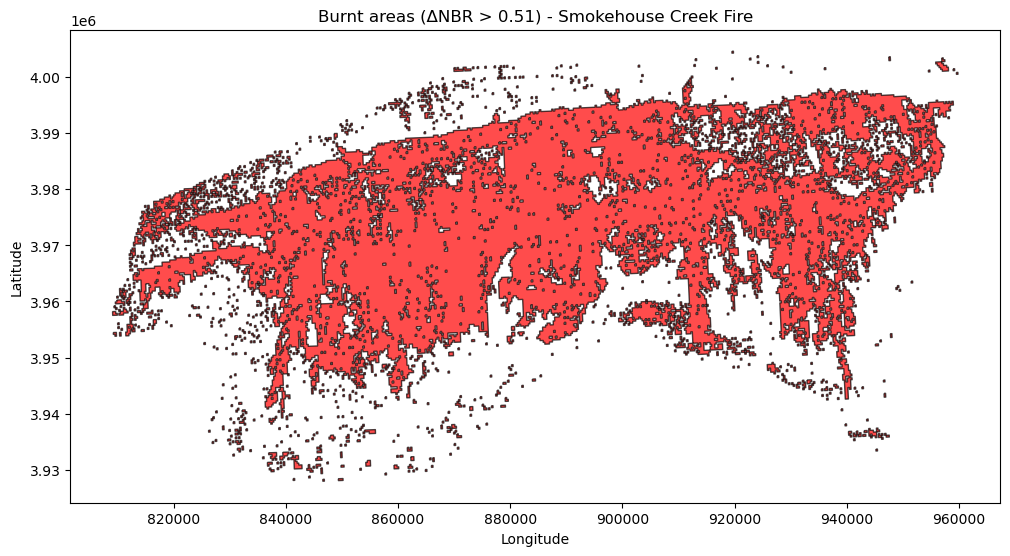

In [107]:
# 1. Load the raster
raster_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\smokehouse_severity.tif"

# 2. Read raster and apply treshold (>0.51)
with rasterio.open(raster_path) as src:
    data = src.read(1)
    transform = src.transform
    crs = src.crs.to_wkt()
    data[data == -9999] = np.nan  
    binary_data = np.where(data > 0.51, 1, 0) 

# 3. Genete polygons (jus burnt areas)
results = (
    {'properties': {'value': v}, 'geometry': s}
    for i, (s, v) in enumerate(shapes(binary_data, transform=transform, connectivity=8))
    if v == 1
)

# 4. Convert to GeoDataFrame y reproject to CRS in meters
gdf = gpd.GeoDataFrame.from_features(list(results), crs=crs)
gdf = gdf.to_crs("EPSG:32613")  # Adjust the EPSG  (ej. 32613 for UTM 13N)

# 5. Clean geometry
gdf['geometry'] = gdf['geometry'].buffer(0).simplify(0.0001)

# 6. Filter min area 
gdf['area_m2'] = gdf['geometry'].area
gdf_filtered = gdf[gdf['area_m2'] >= 4046.86]

# 7. Save results
output_path = r"C:\Users\rpr_2\OneDrive\Escritorio\BOOTCAMP_GIS\5_Setup AWS map services for wildfire assessments\smokehouse\Smokehouse_Polygons.shp"
gdf_filtered.to_file(output_path)

# 8. Mostrar resultados
print(f"\n✅ Polygons created: {len(gdf_filtered)}")


fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)
plt.title("Burnt areas (ΔNBR > 0.51) - Smokehouse Creek Fire")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [124]:
# 1. Autenticación
gis = GIS("home")

# 2. Generar nombres únicos
unique_id = uuid.uuid4().hex[:6]
timestamp = datetime.now().strftime("%Y%m%d")
service_name = f"SmokehouseCreek_Fire_{timestamp}_{unique_id}"
temp_filename = f"temp_smokehouse_{unique_id}.geojson"
temp_file = os.path.join(os.getcwd(), temp_filename)

# 3. Verificar y calcular área si no existe
if 'area_m2' not in gdf.columns:
    print("⚠️ Advertencia: La columna 'area_m2' no existe. Calculando áreas...")
    gdf['area_m2'] = gdf.geometry.area
    
# 4. Conversión a hectáreas
gdf['area_ha'] = gdf['area_m2'] / 10000

# 5. Eliminar columna problemática si existe
if 'area_m2' in gdf.columns:
    gdf = gdf.drop(columns=['area_m2'])

# 6. Exportar a GeoJSON
if os.path.exists(temp_file):
    os.remove(temp_file)
gdf.to_file(temp_file, driver='GeoJSON')

# 7. Configuración de metadatos
item_properties = {
    "title": service_name,
    "tags": "wildfire, Texas, NBR, analysis",
    "type": "GeoJson",
    "description": f"Burned areas - Smokehouse Creek Fire (ΔNBR > 0.51). Generated on {datetime.now().strftime('%d/%m/%Y %H:%M')}"
}

try:
    # 8. Publicar el servicio
    uploaded_item = gis.content.add(item_properties, temp_file)
    published_item = uploaded_item.publish()
    
    # 9. Limpieza
    os.remove(temp_file)
    
    # 10. Resultados
    print("\n✅ Successfully published!")
    print("----------------------------------")
    print(f"📌 Title: {published_item.title}")
    print(f"🔗 URL: {published_item.url}")
    print(f"🆔 ID: {published_item.id}")
    print("----------------------------------")
    
except Exception as e:
    print("\n⚠️ Publication error:")
    print(f"Detail: {str(e)}")
    print("\nℹ️ Alternative solution:")
    print(f"1. Open your browser and go to: https://www.arcgis.com/home/content.html")
    print(f"2. Find and select the file: {temp_filename}")
    print("3. Click 'Publish' and select 'Host as layer'")
   

⚠️ Advertencia: La columna 'area_m2' no existe. Calculando áreas...

✅ Successfully published!
----------------------------------
📌 Title: SmokehouseCreek_Fire_20250409_4814a8
🔗 URL: https://services5.arcgis.com/WFk16FtfNazlisro/arcgis/rest/services/SmokehouseCreek_Fire_20250409_4814a8/FeatureServer
🆔 ID: 4dc7e110e13041499b33cb51696cbd01
----------------------------------


In [ ]:
###################### UPLOADIND EXPERIENCE BUILDER##################

In [125]:
#For better visualization refer to the following link:https://experience.arcgis.com/experience/7e24b9b6e1224041b5c027f5122a6bca"
from arcgis.gis import GIS
gis = GIS("home")

# Obtén tu experiencia
exp_item = gis.content.get("7e24b9b6e1224041b5c027f5122a6bca")
exp_item.share(everyone=True)  # Asegúrate de que sea pública

# Genera HTML interactivo
html_code = f"""
<div style="width:100%; height:800px;">
    <iframe src="{exp_item.url}?embed" width="100%" height="100%" frameborder="0"></iframe>
</div>
"""

from IPython.display import HTML
HTML(html_code)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\IPython\core\interactiveshell.py:3553: DeprecatedWarning: share is deprecated as of 2.3.0 and has be removed in 3.0.0. Use `Item.sharing` instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
